In [6]:
import scipy
from data import One_RNA_Dataset
import pandas as pd
from gae import get_vanilla_model
import torch
from tqdm import tqdm
# Multiprocessing using torch.multiprocessing
import torch.multiprocessing as mp
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from time import time
from sklearn.cluster import AgglomerativeClustering


In [2]:
dataset = One_RNA_Dataset(root='../data/test/')

In [3]:
model = get_vanilla_model(32)
model.load_state_dict(torch.load('../models/with_reconstruction/best_model.pt'))

device = torch.device('cuda')
model = model.to(device)

In [4]:
df = pd.DataFrame(columns=['id', 'pred_embedding'])
for i in tqdm(range(len(dataset))):
    data = dataset[i]
    data.x = data.x.to(device)
    data.edge_index = data.edge_index.to(device)
    with torch.no_grad():
        pred = model.encode(data.x, data.edge_index)
    df.loc[i] = [i, pred.cpu().numpy()]

100%|██████████| 1000/1000 [00:05<00:00, 197.05it/s]


In [12]:
# HCA clustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import numpy as np
from time import time

nb_iter = 100
deb = time()

for _ in range(nb_iter):
    X = np.array(df['pred_embedding'].tolist())
    X = np.mean(X, axis=1)

    hca_clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=0, metric='euclidean', linkage='average')
    hca_clustering.fit(X)

print((time() - deb)/nb_iter)

0.022208507061004638


In [11]:
silhouette_score(X, hca_clustering.labels_)

0.6074375

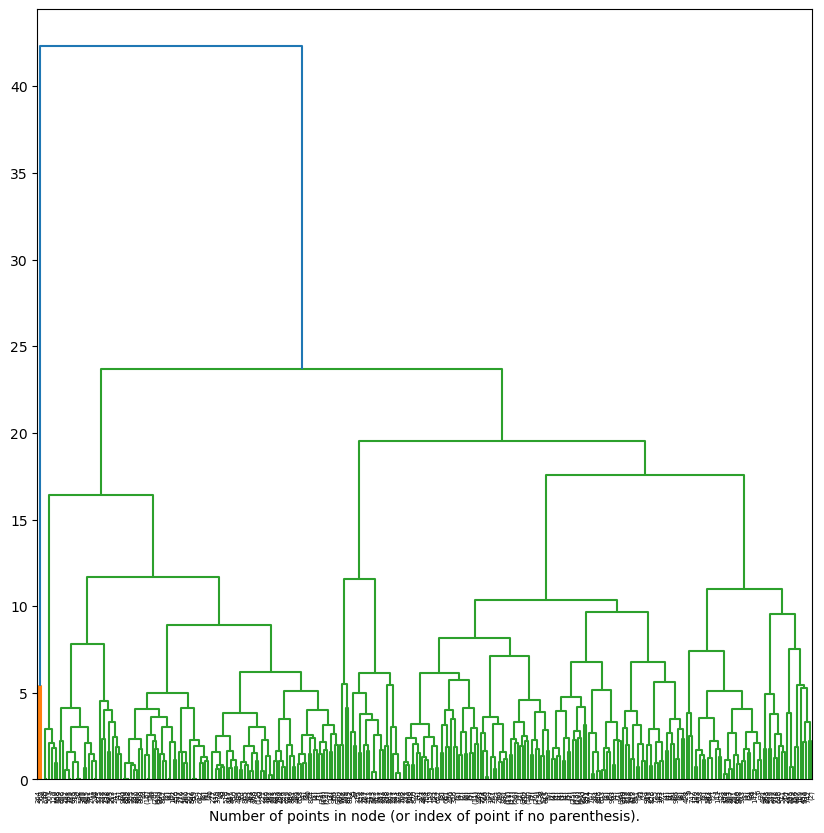

In [17]:

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

plt.figure(figsize=(10, 10))
plot_dendrogram(hca_clustering, truncate_mode='level', p=10)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [11]:
# K-Means clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

nb_iter = 10
deb = time()
for _ in tqdm(range(nb_iter)):
    X = np.array(df['pred_embedding'].tolist())
    X = np.mean(X, axis=1)


    clustering = KMeans(n_clusters=2, init='k-means++', n_init=5, max_iter=300, tol=0.0001)
    clustering.fit(X)
print((time() - deb)/nb_iter)
    

100%|██████████| 10/10 [00:08<00:00,  1.17it/s]

0.8562524795532227


In [17]:
silhouette_score(X, clustering.labels_)


0.6241598853216944

In [26]:
# Compare with dissimilarity matrix from base pair distance matrix
import numpy as np
from matplotlib import pyplot as plt
from utils import base_pair_distance
from data import PairDataset
from torch_geometric.data import DataLoader

X = np.zeros((len(dataset), len(dataset))).flatten()
pair_dataset = PairDataset(dataset, dataset, sample=False)

batch_size = 100
device = torch.device('cuda')

data_loader = DataLoader(pair_dataset, batch_size=batch_size, shuffle=False, follow_batch=["x_1", "x_2"], num_workers=5)

In [ ]:
distance_liste = []

for i, data in tqdm(enumerate(data_loader), total=len(data_loader)):
    with torch.no_grad():
        distances = base_pair_distance(
            data.edge_index_1.to(device),
            data.edge_index_2.to(device),
            batch_1=data.x_1_batch.to(device),
            batch_2=data.x_2_batch.to(device))
        distance_liste.append(distances.cpu().detach())

    

In [30]:
X = torch.cat(distance_liste)

In [32]:
Y = X.reshape(len(dataset), len(dataset))

In [35]:
# Save distance matrix
torch.save(Y, '../data/test/distance_matrix.pt')

In [ ]:
np.save('../data/dissimilarity_matrix.npy', X)

In [ ]:
# Compare with dissimilarity matrix from base pair distance matrix
import numpy as np
from matplotlib import pyplot as plt
from utils import base_pair_distance
from data import PairDataset
from torch_geometric.data import DataLoader

X = np.zeros((len(dataset), len(dataset))).flatten()
pair_dataset = PairDataset(dataset, dataset, sample=False)

# Multiprocessing using torch.multiprocessing
import torch.multiprocessing as mp

batch_size = 50


In [ ]:
import torch
from torch_geometric.data import DataLoader
from torch.multiprocessing import Pool, set_start_method
import numpy as np
from tqdm import tqdm
from utils import base_pair_distance
from data import PairDataset

# Set the start method for multiprocessing
try:
    set_start_method('spawn')
except RuntimeError:
    pass

def compute_distances(batch):
    with torch.no_grad():
        distances = base_pair_distance(
            batch.edge_index_1.to(device),
            batch.edge_index_2.to(device),
            batch_1=batch.x_1_batch.to(device),
            batch_2=batch.x_2_batch.to(device))
        return distances.cpu().detach()


X = np.zeros((len(dataset), len(dataset))).flatten()
pair_dataset = PairDataset(dataset, dataset, sample=False)

batch_size = 50
device = torch.device('cuda')

data_loader = DataLoader(pair_dataset, batch_size=batch_size, shuffle=False, follow_batch=["x_1", "x_2"], num_workers=20)

distance_list = []

with Pool(processes=torch.multiprocessing.cpu_count()) as pool:
    for distances in tqdm(pool.imap(compute_distances, data_loader), total=len(data_loader)):
        distance_list.append(distances)

X = np.concatenate(distance_list)


In [12]:
X = torch.load('../data/test/distance_matrix.pt')

In [13]:
# Compute K-Means clustering

kmeans = KMeans(n_clusters=2, init='k-means++', n_init=5, max_iter=300, tol=0.0001)
kmeans.fit(X)

KMeans(n_clusters=2, n_init=5)

In [14]:
silhouette_score(X, kmeans.labels_)

0.6373688062657415

In [15]:
hca_dissimilarity = AgglomerativeClustering(n_clusters=2, distance_threshold=None, metric='precomputed', linkage='average')
hca_dissimilarity.fit(X)

AgglomerativeClustering(linkage='average', metric='precomputed')

In [16]:
silhouette_score(X, hca_dissimilarity.labels_)

0.7948737369047212